In [362]:
import cv2
import os
from datetime import datetime
import time
import torch
import numpy as np
import math
from pathlib import Path
import csv
import json
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt


# helper to ensure directory
def ensure_dir(p):
    Path(p).mkdir(parents=True, exist_ok=True)


In [363]:
import serial
import time
import threading
import cv2
import os
from pathlib import Path
from datetime import datetime

# ---------------- MOTOR ----------------
puerto = "/dev/ttyUSB0"  # ESP32
baudrate = 115200

def ejecutar_motor():
    try:
        esp = serial.Serial(puerto, baudrate, timeout=1)
        time.sleep(2)  # esperar reinicio
        print("Conectado al ESP32 en", puerto)
    except Exception as e:
        print("Error al conectar:", e)
        return

    # Enviar comando para activar motor
    esp.write(b"motor\n")
    print("Comando 'motor' enviado al ESP32.")

    # Leer la respuesta del ESP32
    while True:
        if esp.in_waiting:
            try:
                respuesta = esp.readline().decode('utf-8', errors='ignore').strip()
                if respuesta:
                    print(respuesta)
                    if "Motor terminado" in respuesta:
                        break
            except Exception as e:
                print("Error leyendo Serial:", e)
        else:
            time.sleep(0.1)

    esp.close()
    print("Puerto serial cerrado.")

# ---------------- CÁMARA ----------------
CAPTURE_COUNT = 20  # número de imágenes a capturar
INTERVAL = 1        # segundos entre capturas
MODEL_FOLDER = Path('.')            
MODEL_FILE_NAME = 'best.pt'      
MODEL_PATH = (MODEL_FOLDER / MODEL_FILE_NAME).resolve()
if not MODEL_PATH.exists():
    raise FileNotFoundError(f'No se encontró el archivo del modelo en {MODEL_PATH}. Ajusta MODEL_FILE_NAME o mueve el archivo junto al notebook.')
print('Usando exclusivamente el modelo:', MODEL_PATH.name)

def ensure_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

def capturar_imagenes():
    # Crear carpeta timestamp
    global carpeta 
    carpeta = datetime.now().strftime('%Y%m%d_%H%M%S')
    ensure_dir(carpeta)

    # Abrir cámara
    cap = cv2.VideoCapture(0)
    if not cap.isOpened():
        raise RuntimeError('No se pudo abrir la cámara. Verifica que tienes una cámara conectada y permisos.')

    for i in range(CAPTURE_COUNT):
        ret, frame = cap.read()
        if ret:
            nombre_archivo = os.path.join(carpeta, f'imagen_{i+1}.jpg')
            cv2.imwrite(nombre_archivo, frame)
            print(f'Imagen {i+1}/{CAPTURE_COUNT} guardada -> {nombre_archivo}')
        else:
            print(f'Frame {i+1} no leído')
        time.sleep(INTERVAL)

    cap.release()
    cv2.destroyAllWindows()
    print(f'Proceso completado. Imágenes guardadas en: {carpeta}')

# ---------------- EJECUCIÓN CONCURRENTE ----------------
# Crear hilos
hilo_motor = threading.Thread(target=ejecutar_motor)
hilo_camara = threading.Thread(target=capturar_imagenes)

# Iniciar hilos
hilo_motor.start()
hilo_camara.start()

# Esperar que ambos terminen
hilo_motor.join()
hilo_camara.join()

print("Motor y captura de imágenes completados.")


Usando exclusivamente el modelo: best.pt
Imagen 1/20 guardada -> 20251126_211555/imagen_1.jpg
Imagen 2/20 guardada -> 20251126_211555/imagen_2.jpg
Conectado al ESP32 en /dev/ttyUSB0
Comando 'motor' enviado al ESP32.
ERR:estado_desconocido: y1||p^L^L^L^L^@p^@
Ejecutando motor...
Imagen 3/20 guardada -> 20251126_211555/imagen_3.jpg
Imagen 4/20 guardada -> 20251126_211555/imagen_4.jpg
Imagen 5/20 guardada -> 20251126_211555/imagen_5.jpg
Imagen 6/20 guardada -> 20251126_211555/imagen_6.jpg
Imagen 7/20 guardada -> 20251126_211555/imagen_7.jpg
Imagen 8/20 guardada -> 20251126_211555/imagen_8.jpg
Imagen 9/20 guardada -> 20251126_211555/imagen_9.jpg
Imagen 10/20 guardada -> 20251126_211555/imagen_10.jpg
Imagen 11/20 guardada -> 20251126_211555/imagen_11.jpg
Imagen 12/20 guardada -> 20251126_211555/imagen_12.jpg
Imagen 13/20 guardada -> 20251126_211555/imagen_13.jpg
Imagen 14/20 guardada -> 20251126_211555/imagen_14.jpg
Imagen 15/20 guardada -> 20251126_211555/imagen_15.jpg
Imagen 16/20 guardad

In [364]:
# --- Cargar el modelo YOLO (solo archivo local ya verificado) ---
backend = None
model = None
model_path = MODEL_PATH
print('Intentando cargar el archivo:', model_path)

# 1) Intento con Ultralytics YOLOv8/YOLO11 (misma librería)
try:
    from ultralytics import YOLO
    print('Cargando modelo local con ultralytics.YOLO...')
    model = YOLO(str(model_path))
    backend = 'ultralytics'
except Exception as e_ultra:
    print('ultralytics no disponible o carga falló:', e_ultra)

# 2) Intento con torch.hub (YOLOv5 custom). Descarga el repo la primera vez.
if model is None:
    try:
        print('Intentando torch.hub (ultralytics/yolov5 custom)...')
        model = torch.hub.load('ultralytics/yolov5', 'custom', path=str(model_path), trust_repo=True, source='github', force_reload=False)
        backend = 'yolov5_hub'
    except Exception as e_hub:
        print('torch.hub tampoco pudo cargar el modelo:', e_hub)

# 3) Intento manual: cargar checkpoint como módulo PyTorch
if model is None:
    try:
        print('Intentando carga manual con torch.load...')
        checkpoint = torch.load(str(model_path), map_location='cpu')
        if isinstance(checkpoint, torch.nn.Module):
            model = checkpoint
            backend = 'torch_module'
        elif isinstance(checkpoint, dict) and 'model' in checkpoint:
            model = checkpoint['model']
            backend = 'torch_state_dict'
        else:
            raise RuntimeError('Formato del checkpoint no reconocido.')
    except Exception as e_manual:
        raise RuntimeError('No se pudo cargar el modelo local. Instala "ultralytics" o exporta el .pt a un formato compatible.') from e_manual

print('Modelo cargado desde archivo local. Backend:', backend)

Intentando cargar el archivo: /home/starkiller/Documentos/8smestre/ia/detector/best.pt
Cargando modelo local con ultralytics.YOLO...
Modelo cargado desde archivo local. Backend: ultralytics


In [365]:
# --- Predecir sobre las imágenes capturadas ---
results_list = []
image_paths = sorted([str(p) for p in Path(carpeta).glob('*.jpg')])
print('Imágenes encontradas:', image_paths)
for img_path in image_paths:
    print('Procesando:', img_path)
    try:
        if backend == 'ultralytics':
            res = model(img_path)[0]  # objeto Results de ultralytics
            boxes = getattr(res, 'boxes', None)
            if boxes is None or len(boxes) == 0:
                results_list.append({'image': img_path, 'class': None, 'conf': 0.0})
                continue
            confidences = boxes.conf.tolist()
            classes = boxes.cls.tolist()
            top_idx = int(np.argmax(confidences))
            top_conf = float(confidences[top_idx])
            top_cls = int(classes[top_idx])
            names = getattr(model, 'names', {}) if hasattr(model, 'names') else {}
            top_name = names.get(top_cls, str(top_cls))
        elif backend in {'torch_module','torch_state_dict'}:
            model.eval()
            img = cv2.imread(img_path)
            if img is None:
                raise RuntimeError('No se pudo leer la imagen para inferencia.')
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            tensor = torch.from_numpy(img_rgb).float().permute(2,0,1).unsqueeze(0) / 255.0
            with torch.no_grad():
                raw = model(tensor)
            # Suponemos salida estilo YOLO (bs, anchors, (5 + num_cls))
            if isinstance(raw, (list, tuple)) and len(raw) > 0:
                raw = raw[0]
            if raw.dim() == 4:
                raw = raw[0]
            raw = raw.cpu().numpy().reshape(-1, raw.shape[-1])
            boxes = raw[:, :4]
            obj_conf = raw[:, 4]
            class_scores = raw[:, 5:]
            scores = obj_conf[:, None] * class_scores
            top_idx = int(np.argmax(scores))
            top_conf = float(np.max(scores))
            top_cls = int(np.argmax(class_scores[top_idx]))
            names = getattr(model, 'names', {}) if hasattr(model, 'names') else {}
            top_name = names.get(top_cls, str(top_cls))
        else:
            raise RuntimeError('Backend no soportado para predicción.')
        results_list.append({'image': img_path, 'class': top_name, 'conf': top_conf})
        print(f' -> {top_name} ({top_conf:.3f})')
    except Exception as e:
        print('Error procesando', img_path, e)
        results_list.append({'image': img_path, 'class': None, 'conf': 0.0})

print('Predicción completada sobre todas las imágenes.')

Imágenes encontradas: ['20251126_211555/imagen_1.jpg', '20251126_211555/imagen_10.jpg', '20251126_211555/imagen_11.jpg', '20251126_211555/imagen_12.jpg', '20251126_211555/imagen_13.jpg', '20251126_211555/imagen_14.jpg', '20251126_211555/imagen_15.jpg', '20251126_211555/imagen_16.jpg', '20251126_211555/imagen_17.jpg', '20251126_211555/imagen_18.jpg', '20251126_211555/imagen_19.jpg', '20251126_211555/imagen_2.jpg', '20251126_211555/imagen_20.jpg', '20251126_211555/imagen_3.jpg', '20251126_211555/imagen_4.jpg', '20251126_211555/imagen_5.jpg', '20251126_211555/imagen_6.jpg', '20251126_211555/imagen_7.jpg', '20251126_211555/imagen_8.jpg', '20251126_211555/imagen_9.jpg']
Procesando: 20251126_211555/imagen_1.jpg

image 1/1 /home/starkiller/Documentos/8smestre/ia/detector/20251126_211555/imagen_1.jpg: 480x640 1 sana, 214.6ms
Speed: 5.1ms preprocess, 214.6ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)
 -> sana (0.934)
Procesando: 20251126_211555/imagen_10.jpg

image 1/1 /ho

In [366]:
# --- Agregación y cálculo de índices ---
import pandas as pd
from collections import Counter
import json

confs = [r['conf'] for r in results_list]
classes = [r['class'] or 'None' for r in results_list]

# Media aritmética
arith_mean = float(np.mean(confs)) if len(confs) > 0 else 0.0
# Media geométrica (evitar ceros con eps)
eps = 1e-9
geom_mean = float(np.exp(np.mean(np.log(np.array(confs) + eps)))) if len(confs) > 0 else 0.0

# Determinar clase final: la que tenga mayor promedio de confianza entre las imágenes donde aparece
class_scores = {}
for r in results_list:
    cls = r['class'] or 'None'
    class_scores.setdefault(cls, []).append(r['conf'])
avg_class_scores = {k: (sum(v) / len(v) if len(v) > 0 else 0.0) for k, v in class_scores.items()}
final_class = max(avg_class_scores.items(), key=lambda x: x[1])[0] if len(avg_class_scores) > 0 else None
final_conf = avg_class_scores.get(final_class, 0.0) if final_class is not None else 0.0

print('Resumen por imagen:')
for r in results_list:
    print(f"{Path(r['image']).name}: {r['class']} ({r['conf']:.3f})")

print('\nPromedios sobre las {} imágenes:'.format(len(confs)))
print(f'Arithmetic mean confidence: {arith_mean:.4f}')
print(f'Geometric mean confidence: {geom_mean:.4f}')
print(f'Final class (mayor avg confidence): {final_class} with {final_conf:.4f}')

# Crear DataFrame para análisis posterior
results_df = pd.DataFrame(results_list)
if not results_df.empty:
    results_df['image_name'] = results_df['image'].apply(lambda p: Path(p).name)
else:
    results_df['image_name'] = []

# Guardar resultados en CSV dentro de la carpeta de la captura
csv_path = Path(carpeta) / 'results.csv'
results_df.to_csv(csv_path, index=False)
print('Resultados guardados en', csv_path)

# Guardar resumen adicional en JSON
summary_payload = {
    'capture_folder': carpeta,
    'image_count': len(results_list),
    'final_class': final_class,
    'final_confidence': final_conf,
    'arithmetic_mean': arith_mean,
    'geometric_mean': geom_mean,
    'class_scores': avg_class_scores,
}
json_path = Path(carpeta) / 'results_summary.json'
with open(json_path, 'w', encoding='utf-8') as f:
    json.dump(summary_payload, f, ensure_ascii=False, indent=2)
print('Resumen JSON guardado en', json_path)

Resumen por imagen:
imagen_1.jpg: sana (0.934)
imagen_10.jpg: sana (0.923)
imagen_11.jpg: sana (0.941)
imagen_12.jpg: sana (0.950)
imagen_13.jpg: sana (0.928)
imagen_14.jpg: sana (0.926)
imagen_15.jpg: sana (0.878)
imagen_16.jpg: sana (0.885)
imagen_17.jpg: sana (0.902)
imagen_18.jpg: sana (0.822)
imagen_19.jpg: sana (0.839)
imagen_2.jpg: sana (0.942)
imagen_20.jpg: sana (0.921)
imagen_3.jpg: sana (0.943)
imagen_4.jpg: sana (0.938)
imagen_5.jpg: sana (0.941)
imagen_6.jpg: sana (0.940)
imagen_7.jpg: sana (0.934)
imagen_8.jpg: sana (0.929)
imagen_9.jpg: sana (0.921)

Promedios sobre las 20 imágenes:
Arithmetic mean confidence: 0.9168
Geometric mean confidence: 0.9162
Final class (mayor avg confidence): sana with 0.9168
Resultados guardados en 20251126_211555/results.csv
Resumen JSON guardado en 20251126_211555/results_summary.json


In [367]:
# --- Visualizar tabla de resultados ---
if 'results_df' not in globals():
    raise RuntimeError('Debes ejecutar las celdas anteriores para generar results_df.')
display(results_df[['image_name','class','conf']])
print('Totales por clase detectada:')
print(results_df['class'].value_counts(dropna=False))

,image_name,class,conf
0,imagen_1.jpg,sana,0.933724
1,imagen_10.jpg,sana,0.922575
2,imagen_11.jpg,sana,0.941473
3,imagen_12.jpg,sana,0.949590
4,imagen_13.jpg,sana,0.927791
5,imagen_14.jpg,sana,0.926421
6,imagen_15.jpg,sana,0.877529
7,imagen_16.jpg,sana,0.884647
8,imagen_17.jpg,sana,0.902460
9,imagen_18.jpg,sana,0.821787


Totales por clase detectada:
class
sana    20
Name: count, dtype: int64


In [368]:
# --- Filtrar detecciones con confianza mínima ---
CONF_THRESHOLD = 0.25
if results_df.empty:
    high_conf = results_df
else:
    high_conf = results_df[results_df['conf'] >= CONF_THRESHOLD].copy()
print(f'Detecciones con conf >= {CONF_THRESHOLD}: {len(high_conf)}')
display(high_conf[['image_name','class','conf']])

Detecciones con conf >= 0.25: 20


,image_name,class,conf
0,imagen_1.jpg,sana,0.933724
1,imagen_10.jpg,sana,0.922575
2,imagen_11.jpg,sana,0.941473
3,imagen_12.jpg,sana,0.949590
4,imagen_13.jpg,sana,0.927791
5,imagen_14.jpg,sana,0.926421
6,imagen_15.jpg,sana,0.877529
7,imagen_16.jpg,sana,0.884647
8,imagen_17.jpg,sana,0.902460
9,imagen_18.jpg,sana,0.821787


In [369]:
# --- Estadísticas por clase ---
if results_df.empty:
    print('No hay predicciones para analizar.')
else:
    class_summary = (
        results_df.groupby('class')['conf']
        .agg(['count','mean','max','min'])
        .rename(columns={'count':'detections','mean':'avg_conf','max':'max_conf','min':'min_conf'})
        .sort_values('avg_conf', ascending=False)
    )
    display(class_summary)

,detections,avg_conf,max_conf,min_conf
class,,,,
sana,20,0.916837,0.94959,0.821787


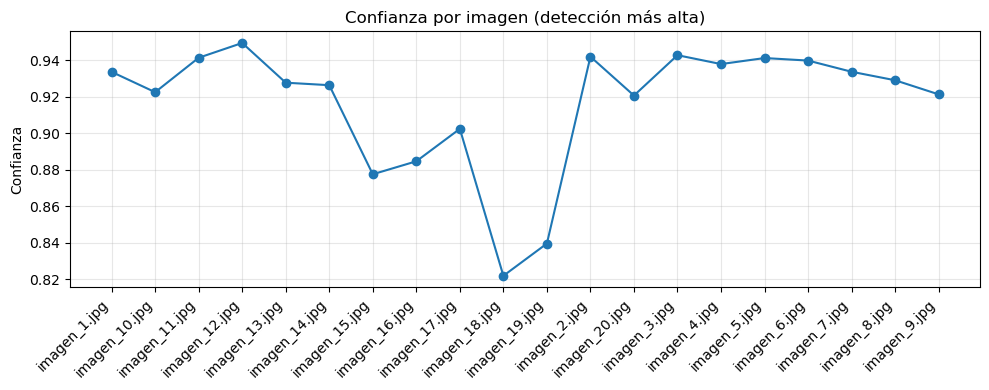

In [370]:
# --- Visualización rápida de las confianzas ---
if results_df.empty:
    print('No hay datos para graficar.')
else:
    plt.figure(figsize=(10,4))
    plt.plot(results_df['image_name'], results_df['conf'], marker='o')
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Confianza')
    plt.title('Confianza por imagen (detección más alta)')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

In [371]:
# --- Función opcional para generar imágenes anotadas ---
def generar_anotaciones(origenes, destino=None):
    if destino is None:
        destino = Path(carpeta) / 'anotadas'
    destino = Path(destino)
    ensure_dir(destino)
    for img_path in origenes:
        try:
            if backend == 'ultralytics':
                res = model(img_path)[0]
                annotated = res.plot()
            else:
                res = model(img_path)
                res.render()
                annotated = res.ims[0]
            salida = destino / f"annotated_{Path(img_path).name}"
            # OpenCV espera BGR
            cv2.imwrite(str(salida), annotated if backend == 'yolov5_hub' else cv2.cvtColor(annotated, cv2.COLOR_RGB2BGR))
            print('Guardada anotación en', salida)
        except Exception as e:
            print('No fue posible anotar', img_path, '->', e)
    return destino


image 1/1 /home/starkiller/Documentos/8smestre/ia/detector/20251126_211555/imagen_1.jpg: 480x640 1 sana, 146.1ms
Speed: 1.5ms preprocess, 146.1ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)
Guardada anotación en 20251126_211555/anotadas/annotated_imagen_1.jpg

image 1/1 /home/starkiller/Documentos/8smestre/ia/detector/20251126_211555/imagen_10.jpg: 480x640 1 sana, 168.2ms
Speed: 1.7ms preprocess, 168.2ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)
Guardada anotación en 20251126_211555/anotadas/annotated_imagen_10.jpg

image 1/1 /home/starkiller/Documentos/8smestre/ia/detector/20251126_211555/imagen_11.jpg: 480x640 1 sana, 160.8ms
Speed: 2.1ms preprocess, 160.8ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)
Guardada anotación en 20251126_211555/anotadas/annotated_imagen_11.jpg

image 1/1 /home/starkiller/Documentos/8smestre/ia/detector/20251126_211555/imagen_12.jpg: 480x640 1 sana, 166.6ms
Speed: 2.7ms preprocess, 166.6ms in

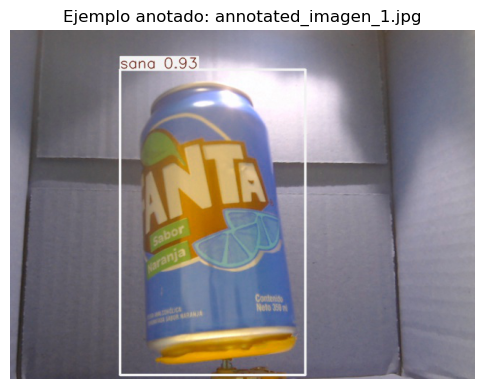

In [372]:
# --- Ejecutar anotaciones y previsualizar una imagen ---
if len(image_paths) == 0:
    print('No hay imágenes para anotar.')
else:
    anotadas_dir = generar_anotaciones(image_paths)
    muestra = sorted(anotadas_dir.glob('annotated_*.jpg'))
    if muestra:
        ejemplo = muestra[0]
        img = cv2.cvtColor(cv2.imread(str(ejemplo)), cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(6,6))
        plt.imshow(img)
        plt.axis('off')
        plt.title(f'Ejemplo anotado: {ejemplo.name}')
        plt.show()
    else:
        print('No se generaron imágenes anotadas.')

In [373]:
# --- Alternativa de decisión final (mayoría simple) ---
if results_df.empty:
    print('No hay datos para calcular mayoría.')
else:
    conteo = Counter(results_df['class'].fillna('None'))
    mayor_clase, mayor_val = conteo.most_common(1)[0]
    print('Clase más frecuente:', mayor_clase, 'con', mayor_val, 'apariciones de', len(results_df))
    print('Distribución completa:')
    for clase, total in conteo.items():
        print(f' - {clase}: {total}')

Clase más frecuente: sana con 20 apariciones de 20
Distribución completa:
 - sana: 20


In [374]:
# --- Limpieza opcional de carpetas antiguas ---
import shutil

def limpiar_capturas_antiguas(base_path='.', conservar=3):
    base = Path(base_path)
    capturas = sorted([p for p in base.glob('20????????_??????') if p.is_dir()])
    excedente = len(capturas) - conservar
    if excedente <= 0:
        print('No hay carpetas para eliminar.')
        return
    for carpeta_antigua in capturas[:excedente]:
        try:
            shutil.rmtree(carpeta_antigua)
            print('Carpeta eliminada:', carpeta_antigua)
        except Exception as e:
            print('No se pudo eliminar', carpeta_antigua, '->', e)

In [375]:
# --- Prueba rápida de cámara ---
def probar_camara(index=0):
    prueba = cv2.VideoCapture(index)
    if not prueba.isOpened():
        print('No se pudo abrir la cámara', index)
        return False
    ret, frame = prueba.read()
    prueba.release()
    if not ret:
        print('La cámara se abrió pero no entregó frames.')
        return False
    print('Cámara', index, 'operativa. Resolución:', frame.shape[1], 'x', frame.shape[0])
    return True

In [376]:
# --- Identificar cámaras conectadas ---
def listar_camaras(max_indices=5):
    disponibles = []
    for idx in range(max_indices):
        cap = cv2.VideoCapture(idx)
        if cap.isOpened():
            ret, _ = cap.read()
            if ret:
                disponibles.append(idx)
                print(f"Cámara {idx}: DISPONIBLE")
            else:
                print(f"Cámara {idx}: abierta pero no entrega frames")
        else:
            print(f"Cámara {idx}: no disponible")
        cap.release()
    if not disponibles:
        print("No se detectaron cámaras operativas en los primeros", max_indices, "indices.")
    else:
        print("Índices utilizables:", disponibles)

# Ejecuta la función para ver las cámaras conectadas
listar_camaras(max_indices=6)


Cámara 0: DISPONIBLE
Cámara 1: no disponible


[ WARN:1@5080.219] global cap_v4l.cpp:914 open VIDEOIO(V4L2:/dev/video1): can't open camera by index


Cámara 2: DISPONIBLE
Cámara 3: no disponible
Cámara 4: no disponible
Cámara 5: no disponible
Índices utilizables: [0, 2]


[ WARN:1@5080.816] global cap_v4l.cpp:914 open VIDEOIO(V4L2:/dev/video3): can't open camera by index
[ WARN:1@5080.816] global cap_v4l.cpp:914 open VIDEOIO(V4L2:/dev/video4): can't open camera by index
[ WARN:1@5080.816] global cap_v4l.cpp:914 open VIDEOIO(V4L2:/dev/video5): can't open camera by index


In [377]:
# --- Conexión serial y envío de estados al ESP32 ---
# Funciones para listar puertos, seleccionar uno y enviar los estados: 'sana', 'danada', 'defectosa'
try:
    import serial
    import serial.tools.list_ports as list_ports
except ImportError:
    import sys, subprocess
    print('pyserial no instalado. Instalando pyserial...')
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'pyserial'])
    import serial
    import serial.tools.list_ports as list_ports
import time

VALID_STATES = ("sana", "danada", "defectosa")


def listar_puertos():
    """Devuelve lista de puertos serial disponibles y los imprime."""
    ports = list(list_ports.comports())
    dispositivos = []
    if not ports:
        print("No se encontraron puertos serie disponibles.")
        return dispositivos
    for i, p in enumerate(ports):
        print(f"{i}: {p.device} - {p.description}")
        dispositivos.append(p.device)
    return dispositivos


def seleccionar_puerto(preferido: str = None):
    """Selecciona un puerto. Si 'preferido' está presente, lo devuelve; si no, devuelve el primero encontrado."""
    puertos = listar_puertos()
    if not puertos:
        return None
    if preferido and preferido in puertos:
        print(f"Usando puerto preferido: {preferido}")
        return preferido
    if len(puertos) == 1:
        print(f"Seleccionado puerto: {puertos[0]}")
        return puertos[0]
    print(f"Varios puertos disponibles, se selecciona por defecto: {puertos[0]}\nPara usar otro, llama seleccionar_puerto('/dev/ttyUSB1')")
    return puertos[0]


def send_state(port: str, state: str, baud: int = 115200, timeout: float = 1.0):
    """Envía un estado por serial y lee una respuesta opcional.

    Args:
        port: ruta del puerto (por ejemplo '/dev/ttyUSB0')
        state: uno de VALID_STATES
        baud: velocidad en baudios
        timeout: tiempo de espera en segundos

    Returns:
        La respuesta leída (string) o None si no hay respuesta.
    """
    if state not in VALID_STATES:
        raise ValueError(f"Estado inválido: {state}. Usa uno de: {VALID_STATES}")
    if port is None:
        raise RuntimeError("Puerto no especificado. Usa seleccionar_puerto() para obtener uno.")

    try:
        ser = serial.Serial(port, baudrate=baud, timeout=timeout)
    except Exception as e:
        raise RuntimeError(f"No se pudo abrir el puerto {port}: {e}") from e

    try:
        # Dar tiempo para que el dispositivo se estabilice
        time.sleep(0.1)
        payload = (state + "\n").encode()
        ser.write(payload)
        # Intentar leer una línea de respuesta (si el ESP32 responde)
        try:
            resp = ser.readline().decode(errors='ignore').strip()
        except Exception:
            resp = None
        print(f"Enviado: '{state}' -> {port} ; Respuesta: '{resp}'")
        return resp
    finally:
        ser.close()


# Función rápida que detecta puerto y envía el estado dado (útil para pruebas)
def enviar_estado_auto(state: str, preferido: str = None):
    port = seleccionar_puerto(preferido)
    if port is None:
        raise RuntimeError('No hay puertos serial disponibles para enviar el estado.')
    return send_state(port, state)


print('Celda de serial cargada. Ejecuta listar_puertos() para ver los puertos.')
print('Usar: seleccionar_puerto() o enviar_estado_auto("sana") para pruebas.')


Celda de serial cargada. Ejecuta listar_puertos() para ver los puertos.
Usar: seleccionar_puerto() o enviar_estado_auto("sana") para pruebas.


In [378]:
# --- Enviar resultado final al ESP32 (usa funciones serial ya definidas)
# Esta celda toma 'results_list' o 'results_df', calcula la clase con mayor promedio de confianza
# y manda el estado mapeado ('sana','danada','defectosa') al ESP32 usando enviar_estado_auto o send_state.

# Mapeo por defecto: ajusta según tus clases reales
CLASS_TO_STATE = {
    'person': 'danada',
    'none': 'sana',
    'sana': 'sana',
    'defect': 'defectosa',
    'defectosa': 'defectosa',
    'defectuosa': 'defectosa'
}

# Si ya sabes el puerto y la placa, configúralos aquí para pruebas automáticas
PREFERRED_PORT = '/dev/ttyUSB0'  # cambia si tu puerto es distinto
BOARD_NAME = 'ESP32 Dev Module'  # nombre de tu placa (solo informativo)

print(f"Usando puerto preferido: {PREFERRED_PORT} ; Board: {BOARD_NAME}")


def decide_and_send():
    import time, traceback
    # Determinar final_class/final_conf a partir de results_list o results_df
    try:
        if 'results_df' in globals() and not results_df.empty:
            # Construir promedios por clase a partir de results_list (si existe)
            class_scores = {}
            for r in results_list:
                cls = (r.get('class') or 'None')
                class_scores.setdefault(cls, []).append(r.get('conf', 0.0))
            avg_class_scores = {k: (sum(v)/len(v) if len(v)>0 else 0.0) for k,v in class_scores.items()}
            final_class = max(avg_class_scores.items(), key=lambda x: x[1])[0] if len(avg_class_scores)>0 else 'None'
            final_conf = avg_class_scores.get(final_class, 0.0)
        elif 'final_class' in globals():
            final_class = final_class
            final_conf = globals().get('final_conf', 0.0)
        else:
            raise RuntimeError('No hay resultados para decidir. Ejecuta las celdas de captura y predicción primero.')

        print('Clase final decidida:', final_class, 'conf:', final_conf)
        key = str(final_class).lower() if final_class is not None else 'none'
        state = CLASS_TO_STATE.get(key)
        if state is None:
            # Si la clase no está mapeada: si es 'None' -> sana, else -> danada
            if key in ('none','nan',''):
                state = 'sana'
            else:
                state = 'danada'
        print('Estado que se enviará:', state)

        # Intentar enviar usando la función de mayor nivel primero (enviar_estado_auto), si falla hacer fallback
        resp = None
        sent = False

        # 1) Intento directo con enviar_estado_auto (si existe)
        if 'enviar_estado_auto' in globals():
            try:
                print('Intentando enviar con enviar_estado_auto(...)')
                # pasar el puerto preferido para forzar uso de /dev/ttyUSB0 si está conectado
                resp = enviar_estado_auto(state, preferido=PREFERRED_PORT)
                print('Respuesta enviar_estado_auto:', resp)
                sent = True
            except Exception as e:
                print('Error en enviar_estado_auto:', e)
                traceback.print_exc()
                sent = False

        # 2) Fallback: intentar seleccionar puerto y usar send_state
        if not sent:
            try:
                print('FALLBACK: intentando enviar con send_state(...)')
                port = None
                if 'seleccionar_puerto' in globals():
                    try:
                        port = seleccionar_puerto(PREFERRED_PORT)
                        print('Puerto seleccionado por seleccionar_puerto():', port)
                    except Exception as e:
                        print('seleccionar_puerto falló:', e)
                        port = None

                # si aún no hay puerto, intentar listar puertos y escoger manualmente
                if port is None and 'listar_puertos' in globals():
                    try:
                        ports = listar_puertos()
                        print('Puertos detectados:', ports)
                        if PREFERRED_PORT in ports:
                            port = PREFERRED_PORT
                        elif ports:
                            port = ports[0]
                    except Exception as e:
                        print('listar_puertos falló:', e)
                        port = None

                if port is None:
                    raise RuntimeError('No se encontró ningún puerto serie disponible para enviar el estado.')

                # usar baudrate si está definido en el kernel (ej.: variable global 'baudrate')
                baud_to_use = globals().get('baudrate', 115200)
                resp = send_state(port, state, baud=baud_to_use)
                print('Respuesta send_state:', resp)
                sent = True
            except Exception as e:
                print('Error en fallback send_state:', e)
                traceback.print_exc()
                sent = False

        if not sent:
            print('No fue posible enviar el estado. Revisa conexión serie y permisos.')

        return state, resp
    except Exception as e:
        print('Error en decide_and_send:')
        traceback.print_exc()
        raise


# Ejecutar la decisión y envío una sola vez (esto no entra al bucle de vídeo)
print('Ejecutando decide_and_send() ...')
try:
    estado_enviado, respuesta = decide_and_send()
    print(f'Estado enviado: {estado_enviado} ; Respuesta: {respuesta}')
except Exception as e:
    print('No se pudo enviar el estado automáticamente:', e)


Usando puerto preferido: /dev/ttyUSB0 ; Board: ESP32 Dev Module
Ejecutando decide_and_send() ...
Clase final decidida: sana conf: 0.9168366700410843
Estado que se enviará: sana
Intentando enviar con enviar_estado_auto(...)
0: /dev/ttyS31 - n/a
1: /dev/ttyS30 - n/a
2: /dev/ttyS29 - n/a
3: /dev/ttyS28 - n/a
4: /dev/ttyS27 - n/a
5: /dev/ttyS26 - n/a
6: /dev/ttyS25 - n/a
7: /dev/ttyS24 - n/a
8: /dev/ttyS23 - n/a
9: /dev/ttyS22 - n/a
10: /dev/ttyS21 - n/a
11: /dev/ttyS20 - n/a
12: /dev/ttyS19 - n/a
13: /dev/ttyS18 - n/a
14: /dev/ttyS17 - n/a
15: /dev/ttyS16 - n/a
16: /dev/ttyS15 - n/a
17: /dev/ttyS14 - n/a
18: /dev/ttyS13 - n/a
19: /dev/ttyS12 - n/a
20: /dev/ttyS11 - n/a
21: /dev/ttyS10 - n/a
22: /dev/ttyS9 - n/a
23: /dev/ttyS8 - n/a
24: /dev/ttyS7 - n/a
25: /dev/ttyS6 - n/a
26: /dev/ttyS5 - n/a
27: /dev/ttyS4 - n/a
28: /dev/ttyS3 - n/a
29: /dev/ttyS2 - n/a
30: /dev/ttyS1 - n/a
31: /dev/ttyS0 - n/a
32: /dev/ttyUSB0 - CP2102 USB to UART Bridge Controller - CP2102 USB to UART Bridge Controlle

In [379]:
# # --- Detección en vivo desde la cámara ---
# if 'model' not in globals() or model is None:
#     raise RuntimeError('Primero carga el modelo ejecutando las celdas iniciales.')

# if 'backend' not in globals() or backend is None:
#     raise RuntimeError('No se detectó backend para el modelo cargado.')

# TARGET_WIDTH = 640  # reduce la resolución para acelerar la inferencia
# WINDOW_NAME = 'Deteccion en vivo'

# cap_live = cv2.VideoCapture(2)
# if not cap_live.isOpened():
#     raise RuntimeError('No se pudo abrir la cámara para la detección en vivo.')

# cv2.namedWindow(WINDOW_NAME, cv2.WINDOW_NORMAL)
# cv2.resizeWindow(WINDOW_NAME, 800, 600)
# print("Ventana abierta. Presiona 'q' o cierra la ventana para salir.")
# try:
#     while True:
#         ret, frame = cap_live.read()
#         if not ret:
#             print('No se recibió frame nuevo; finalizando.')
#             break

#         frame_for_model = frame
#         h, w = frame.shape[:2]
#         if w > TARGET_WIDTH:
#             scale = TARGET_WIDTH / w
#             new_size = (TARGET_WIDTH, int(h * scale))
#             frame_for_model = cv2.resize(frame, new_size, interpolation=cv2.INTER_AREA)

#         frame_to_show = frame
#         try:
#             if backend == 'ultralytics':
#                 res = model(frame_for_model, verbose=False)[0]
#                 annotated = res.plot()
#                 frame_to_show = cv2.resize(annotated, (w, h), interpolation=cv2.INTER_LINEAR)
#             elif backend == 'yolov5_hub':
#                 res = model(frame_for_model)
#                 res.render()
#                 frame_to_show = cv2.resize(res.ims[0], (w, h), interpolation=cv2.INTER_LINEAR)
#         except Exception as live_err:
#             print('Error durante la inferencia en vivo:', live_err)
#             frame_to_show = frame

#         cv2.imshow(WINDOW_NAME, frame_to_show)
#         key = cv2.waitKey(1) & 0xFF
#         if key == ord('q'):
#             break
#         if cv2.getWindowProperty(WINDOW_NAME, cv2.WND_PROP_VISIBLE) < 1:
#             print('Ventana cerrada por el usuario.')
#             break
# finally:
#     cap_live.release()
#     cv2.destroyWindow(WINDOW_NAME)
#     print('Detección en vivo finalizada.')

In [380]:
# # --- Interfaz visual: botón para ejecutar todo y panel de estado ---
# try:
#     import ipywidgets as widgets
#     from IPython.display import display, clear_output
# except Exception as e:
#     import sys, subprocess
#     print('ipywidgets no está instalado. Instalando...')
#     subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'ipywidgets'])
#     import ipywidgets as widgets
#     from IPython.display import display, clear_output

# out = widgets.Output(layout={'border': '1px solid #ccc'})
# run_btn = widgets.Button(description='Ejecutar pipeline (capturar → predecir → enviar)', button_style='primary')
# run_all_btn = widgets.Button(description='Ejecutar celdas ANTERIORES (modo kernel-only)', button_style='info')


# def _safe_get(varname, default=None):
#     return globals().get(varname, default)


# def on_run(btn):                                                                                                                                                                                                                                                       
#     from pathlib import Path
#     import time, traceback, shutil
#     with out:
#         clear_output()
#         print('Iniciando pipeline...')

#         # Verificar modelo cargado
#         if _safe_get('model', None) is None or _safe_get('backend', None) is None:
#             print('Error: no hay modelo cargado. Ejecuta la celda de carga del modelo primero o usa el botón de ejecutar celdas ANTERIORES (kernel-only).')
#             return

#         # Parámetros (usar los existentes si están definidos)
#         CAPTURE_COUNT_LOCAL = _safe_get('CAPTURE_COUNT', 10)
#         INTERVAL_LOCAL = _safe_get('INTERVAL', 0.5)
#         CAMERA_INDEX = _safe_get('cap', None)
#         # si cap no es objeto, usar índice por defecto 2
#         if isinstance(CAMERA_INDEX, int):
#             cam_idx = CAMERA_INDEX
#         else:
#             cam_idx = 2

#         # Carpeta de captura
#         carpeta_local = datetime.now().strftime('%Y%m%d_%H%M%S_ui')
#         ensure_dir(carpeta_local)
#         print(f'Carpeta creada: {carpeta_local}')

#         # Capturar imágenes
#         cap_widget = cv2.VideoCapture(cam_idx)
#         if not cap_widget.isOpened():
#             print(f'No se pudo abrir la cámara index={cam_idx}. Ejecuta listar_camaras() para verificar índices.')
#             return
#         for i in range(CAPTURE_COUNT_LOCAL):
#             ret, frame = cap_widget.read()
#             if not ret:
#                 print(f'Frame {i+1} no leído')
#                 continue
#             fname = os.path.join(carpeta_local, f'imagen_{i+1}.jpg')
#             cv2.imwrite(fname, frame)
#             print(f'Guardada {fname}')
#             time.sleep(INTERVAL_LOCAL)
#         cap_widget.release()

#         # Inferencia
#         print('\nEjecutando inferencia sobre las imágenes capturadas...')
#         image_paths_local = sorted([str(p) for p in Path(carpeta_local).glob('*.jpg')])
#         results_local = []
#         backend_local = _safe_get('backend')
#         model_local = _safe_get('model')
#         for img_path in image_paths_local:
#             try:
#                 if backend_local == 'ultralytics':
#                     res = model_local(img_path)[0]
#                     boxes = getattr(res, 'boxes', None)
#                     if boxes is None or len(boxes) == 0:
#                         results_local.append({'image': img_path, 'class': None, 'conf': 0.0})
#                         continue
#                     confidences = boxes.conf.tolist()
#                     classes = boxes.cls.tolist()
#                     top_idx = int(np.argmax(confidences))
#                     top_conf = float(confidences[top_idx])
#                     top_cls = int(classes[top_idx])
#                     names = getattr(model_local, 'names', {}) if hasattr(model_local, 'names') else {}
#                     top_name = names.get(top_cls, str(top_cls))
#                 else:
#                     # intentar usar la lógica existente simplificada
#                     model_local.eval()
#                     img = cv2.imread(img_path)
#                     img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#                     tensor = torch.from_numpy(img_rgb).float().permute(2,0,1).unsqueeze(0) / 255.0
#                     with torch.no_grad():
#                         raw = model_local(tensor)
#                     if isinstance(raw, (list, tuple)) and len(raw) > 0:
#                         raw = raw[0]
#                     if hasattr(raw, 'dim') and raw.dim() == 4:
#                         raw = raw[0]
#                     raw = raw.cpu().numpy().reshape(-1, raw.shape[-1])
#                     obj_conf = raw[:,4]
#                     class_scores = raw[:,5:]
#                     scores = obj_conf[:, None] * class_scores
#                     top_idx = int(np.argmax(scores))
#                     top_conf = float(np.max(scores))
#                     top_cls = int(np.argmax(class_scores[top_idx]))
#                     names = getattr(model_local, 'names', {}) if hasattr(model_local, 'names') else {}
#                     top_name = names.get(top_cls, str(top_cls))
#                 results_local.append({'image': img_path, 'class': top_name, 'conf': top_conf})
#                 print(f' -> {Path(img_path).name}: {top_name} ({top_conf:.3f})')
#             except Exception as e:
#                 print('Error en inferencia:', e)
#                 traceback.print_exc()
#                 results_local.append({'image': img_path, 'class': None, 'conf': 0.0})

#         # Generar y guardar imágenes anotadas (si es posible)
#         try:
#             anotadas_dir = Path(carpeta_local) / 'anotadas'
#             ensure_dir(anotadas_dir)
#             print('\nGenerando imágenes anotadas en:', anotadas_dir)
#             for img_path in image_paths_local:
#                 try:
#                     if backend_local == 'ultralytics':
#                         res = model_local(img_path)[0]
#                         annotated = res.plot()
#                         salida = anotadas_dir / f"annotated_{Path(img_path).name}"
#                         # res.plot() devuelve RGB
#                         cv2.imwrite(str(salida), cv2.cvtColor(annotated, cv2.COLOR_RGB2BGR))
#                     elif backend_local == 'yolov5_hub':
#                         res = model_local(img_path)
#                         res.render()
#                         annotated = res.ims[0]
#                         salida = anotadas_dir / f"annotated_{Path(img_path).name}"
#                         # ultralytics/v5 differences handled similarly to generar_anotaciones
#                         cv2.imwrite(str(salida), annotated if backend_local == 'yolov5_hub' else cv2.cvtColor(annotated, cv2.COLOR_RGB2BGR))
#                     else:
#                         # Fallback: copiar la original si no podemos anotar
#                         salida = anotadas_dir / f"annotated_{Path(img_path).name}"
#                         shutil.copy(img_path, str(salida))
#                     print('Guardada anotada:', salida)
#                 except Exception as e:
#                     print('No fue posible anotar', img_path, '->', e)
#         except Exception as e:
#             print('Error generando anotadas:', e)

#         # Agregación
#         confs_local = [r['conf'] for r in results_local]
#         class_scores_local = {}
#         for r in results_local:
#             cls = r['class'] or 'None'
#             class_scores_local.setdefault(cls, []).append(r['conf'])
#         avg_class_scores_local = {k: (sum(v)/len(v) if len(v)>0 else 0.0) for k,v in class_scores_local.items()}
#         final_class_local = max(avg_class_scores_local.items(), key=lambda x: x[1])[0] if len(avg_class_scores_local)>0 else 'None'
#         final_conf_local = avg_class_scores_local.get(final_class_local, 0.0)
#         print('\nDecisión final:', final_class_local, f'conf={final_conf_local:.3f}')

#         # Mostrar tabla resumida
#         try:
#             import pandas as pd
#             df_local = pd.DataFrame(results_local)
#             display(df_local[['image','class','conf']])
#         except Exception:
#             df_local = None

#         # Guardar resultados globales para inspección
#         try:
#             globals().update({
#                 'results_list': results_local,
#                 'results_df': df_local if df_local is not None else pd.DataFrame(results_local),
#                 'final_class': final_class_local,
#                 'final_conf': final_conf_local,
#                 'carpeta': carpeta_local
#             })
#             print('Variables results_list, results_df, final_class, final_conf y carpeta guardadas en el kernel.')
#         except Exception as e:
#             print('No fue posible guardar variables globales:', e)

#         # Mapear a estado y enviar (si existe la función serial)
#         key_local = str(final_class_local).lower() if final_class_local is not None else 'none'
#         CLASS_TO_STATE_LOCAL = _safe_get('CLASS_TO_STATE', { 'person':'danada','none':'sana' })
#         state_local = CLASS_TO_STATE_LOCAL.get(key_local)
#         if state_local is None:
#             state_local = 'sana' if key_local in ('none','nan','') else 'danada'
#         print('Estado determinado:', state_local)
#         if 'enviar_estado_auto' in globals():
#             try:
#                 resp_local = enviar_estado_auto(state_local, preferido=_safe_get('PREFERRED_PORT', None))
#                 print('Respuesta del dispositivo:', resp_local)
#             except Exception as e:
#                 print('Error enviando por serial:', e)
#                 traceback.print_exc()
#         else:
#             print('Función serial no disponible. Ejecuta la celda de serial primero.')


# def on_run_all(btn):
#     """Modo kernel-only: cargar modelo + serial si faltan y ejecutar pipeline en el kernel.
#     Esto evita depender del front-end JS (útil en VS Code / JupyterLab)."""
#     import traceback, subprocess, sys
#     with out:
#         clear_output()
#         print('Modo kernel-only: verificando y cargando dependencias...')

#         # 1) Asegurar que MODEL_PATH esté definido
#         MODEL_PATH_LOCAL = _safe_get('MODEL_PATH', None)
#         if MODEL_PATH_LOCAL is None:
#             print('ERROR: MODEL_PATH no está definido en el kernel. Define MODEL_PATH o ejecuta la celda de configuración antes.')
#             return

#         # 2) Cargar modelo si hace falta
#         if _safe_get('model', None) is None or _safe_get('backend', None) is None:
#             print('Modelo no cargado: intentando carga desde', MODEL_PATH_LOCAL)
#             try:
#                 # intentar ultralytics
#                 try:
#                     from ultralytics import YOLO
#                     m = YOLO(str(MODEL_PATH_LOCAL))
#                     globals()['model'] = m
#                     globals()['backend'] = 'ultralytics'
#                     print('Modelo cargado con ultralytics.')
#                 except Exception as e1:
#                     print('ultralytics no disponible o falló:', e1)
#                     # intentar torch.hub
#                     try:
#                         print('Intentando torch.hub...')
#                         m = torch.hub.load('ultralytics/yolov5', 'custom', path=str(MODEL_PATH_LOCAL), trust_repo=True, source='github', force_reload=False)
#                         globals()['model'] = m
#                         globals()['backend'] = 'yolov5_hub'
#                         print('Modelo cargado con torch.hub (yolov5).')
#                     except Exception as e2:
#                         print('torch.hub falló:', e2)
#                         # intentar torch.load
#                         try:
#                             ckpt = torch.load(str(MODEL_PATH_LOCAL), map_location='cpu')
#                             if isinstance(ckpt, torch.nn.Module):
#                                 globals()['model'] = ckpt
#                                 globals()['backend'] = 'torch_module'
#                             elif isinstance(ckpt, dict) and 'model' in ckpt:
#                                 globals()['model'] = ckpt['model']
#                                 globals()['backend'] = 'torch_state_dict'
#                             else:
#                                 raise RuntimeError('Formato del checkpoint no reconocido.')
#                             print('Modelo cargado con torch.load.')
#                         except Exception as e3:
#                             print('No fue posible cargar el modelo:', e3)
#                             traceback.print_exc()
#                             return
#             except Exception as e:
#                 print('Error durante la carga del modelo:', e)
#                 traceback.print_exc()
#                 return
#         else:
#             print('Modelo ya cargado en el kernel. Backend:', _safe_get('backend'))

#         # 3) Asegurar funciones de serial
#         if 'enviar_estado_auto' not in globals() or 'send_state' not in globals():
#             print('Funciones serial no detectadas: definiendo helpers mínimos (pyserial).')
#             try:
#                 import serial, serial.tools.list_ports as list_ports
#             except Exception:
#                 print('pyserial no encontrado. Instalando...')
#                 subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'pyserial'])
#                 import serial, serial.tools.list_ports as list_ports

#             def listar_puertos_min():
#                 ports = list(list_ports.comports())
#                 return [p.device for p in ports]

#             def seleccionar_puerto_min(preferido: str = None):
#                 ps = listar_puertos_min()
#                 if not ps:
#                     return None
#                 if preferido and preferido in ps:
#                     return preferido
#                 return ps[0]

#             def send_state_min(port: str, state: str, baud: int = 115200, timeout: float = 1.0):
#                 if port is None:
#                     raise RuntimeError('Puerto no especificado para send_state_min')
#                 ser = serial.Serial(port, baudrate=baud, timeout=timeout)
#                 try:
#                     time.sleep(0.1)
#                     ser.write((state + '\n').encode())
#                     try:
#                         resp = ser.readline().decode(errors='ignore').strip()
#                     except Exception:
#                         resp = None
#                     print(f"Enviado: '{state}' -> {port} ; Respuesta: '{resp}'")
#                     return resp
#                 finally:
#                     ser.close()

#             def enviar_estado_auto_min(state: str, preferido: str = None):
#                 port = seleccionar_puerto_min(preferido)
#                 if port is None:
#                     raise RuntimeError('No se encontraron puertos serie para enviar el estado.')
#                 return send_state_min(port, state)

#             globals().update({
#                 'listar_puertos': listar_puertos_min,
#                 'seleccionar_puerto': seleccionar_puerto_min,
#                 'send_state': send_state_min,
#                 'enviar_estado_auto': enviar_estado_auto_min
#             })
#             print('Helpers serial mínimos definidos.')
#         else:
#             print('Funciones serial ya definidas en el kernel.')

#         # 4) Ejecutar pipeline (llamar a on_run) para capturar → predecir → agregar → enviar
#         print('\nEjecutando pipeline de captura/predicción/envío en modo kernel-only...')
#         try:
#             on_run(None)
#         except Exception as e:
#             print('Error ejecutando pipeline en modo kernel-only:', e)
#             traceback.print_exc()


# run_btn.on_click(on_run)
# run_all_btn.on_click(on_run_all)

# # Mostrar los botones y el panel de salida
# display(widgets.VBox([widgets.HBox([run_all_btn, run_btn]), out]))
